## Autoencoders


This notebook covers

* Autoencoders and variational autoencoders (VAEs) and their differences 
* Building and training an autoencoder from scratch to generate handwritten digits
* Building and training an autoencoder on tinyimagenet dataset
* Building and training a VAE from scratch to generate human face images
* Performing encoding arithmetic with the trained VAE

### What is an autoencoder?

The primary goal of an AE is to learn a compressed representation of the input data, focusing on minimizing the reconstruction error - the difference between the original input and its reconstruction.


### 1. Build and train an autoencoder to generate digits


**1.1 Import libraries and load MNIST data**

In [1]:
import torchvision
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"

In [1]:
transform=T.Compose([
    T.ToTensor()])
train_set=torchvision.datasets.MNIST(root=".",
    train=True,download=True,transform=transform) 
test_set=torchvision.datasets.MNIST(root=".",
    train=False,download=True,transform=transform) 

batch_size=32
train_loader=torch.utils.data.DataLoader(
    train_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(
    test_set,batch_size=batch_size,shuffle=True)

**1.2. Build and train an autoencoder**

In [3]:
input_dim = 784
z_dim = 20
h_dim = 200
class AE(nn.Module):
    def __init__(self,input_dim,z_dim,h_dim):
        super().__init__()
        self.common = nn.Linear(input_dim, h_dim)
        self.encoded = nn.Linear(h_dim, z_dim)
        self.l1 = nn.Linear(z_dim, h_dim)
        self.decode = nn.Linear(h_dim, input_dim)                
    def encoder(self, x):
        common = F.relu(self.common(x))
        mu = self.encoded(common)
        return mu
    def decoder(self, z):
        out=F.relu(self.l1(z))
        out=torch.sigmoid(self.decode(out))
        return out
    def forward(self, x):
        mu=self.encoder(x)
        out=self.decoder(mu)
        return out, mu

In [4]:
model = AE(input_dim,z_dim,h_dim).to(device)
lr=0.00025
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [5]:
# collect a sample for each digit
originals = []
idx = 0
for img,label in test_set:
    if label == idx:
        originals.append(img)
        idx += 1
    if idx == 10:
        break

def plot_digits():
    reconstructed=[]
    for idx in range(10):
        # reconstruct the digit image
        with torch.no_grad():
            img = originals[idx].reshape((1,input_dim))
            out,mu = model(img.to(device))
        reconstructed.append(out)
    # Plot both the original and the reconstructed
    imgs=originals+reconstructed
    plt.figure(figsize=(10,2),dpi=50)
    for i in range(20):
        ax = plt.subplot(2,10, i + 1)
        img=(imgs[i]).detach().cpu().numpy()
        plt.imshow(img.reshape(28,28),
                   cmap="binary")
        plt.xticks([])
        plt.yticks([])
    plt.show()  

at epoch 0 toal loss = 1894931.5452270508


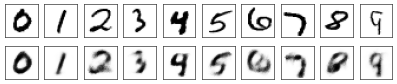

at epoch 1 toal loss = 879609.0616455078


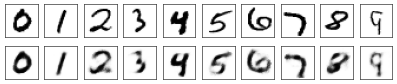

at epoch 2 toal loss = 712907.1156616211


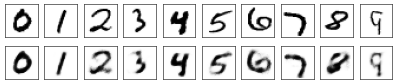

at epoch 3 toal loss = 644760.87890625


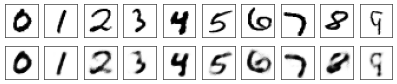

at epoch 4 toal loss = 602463.1360626221


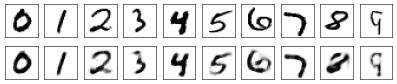

at epoch 5 toal loss = 571677.449508667


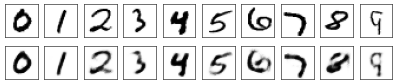

at epoch 6 toal loss = 548055.5870666504


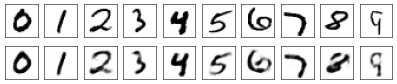

at epoch 7 toal loss = 528461.7652282715


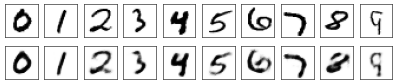

at epoch 8 toal loss = 512092.8200378418


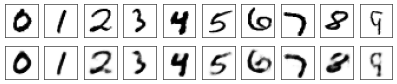

at epoch 9 toal loss = 498104.00701904297


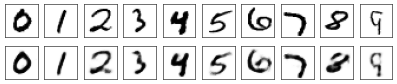

In [7]:
for epoch in range(10):
    tloss=0
    for imgs, labels in train_loader:
        # reconstruct the images
        imgs=imgs.to(device).view(-1, input_dim)
        out, mu=model(imgs)
        # reconstruction loss (MSE)
        loss=((out-imgs)**2).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss+=loss.item()
    print(f"at epoch {epoch} toal loss = {tloss}")
    # visualize the reconstructed digits
    plot_digits()

**1.3. Save and Use the trained Autoencoder**

In [8]:
# Export to TorchScript
scripted = torch.jit.script(model) 
# Save the model
scripted.save('files/AEdigits.pt') 

In [9]:
model=torch.jit.load('files/AEdigits.pt',map_location=device)
model.eval()

RecursiveScriptModule(
  original_name=AE
  (common): RecursiveScriptModule(original_name=Linear)
  (encoded): RecursiveScriptModule(original_name=Linear)
  (l1): RecursiveScriptModule(original_name=Linear)
  (decode): RecursiveScriptModule(original_name=Linear)
)

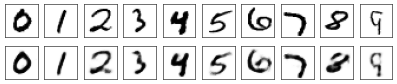

In [10]:
plot_digits()

### 2. Autoencoders on TinyImagenet dataset

In [2]:
from src.tinyimagenet_dataset import get_tinyimagenet_dataloaders
from src.models import get_model, count_parameters
from src.trainer import create_trainer
from src.utils import visualize_reconstructions

/workspace/repo/dl-lab-notebooks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**2.1 Load the dataset**

In [3]:
train_loader, val_loader = get_tinyimagenet_dataloaders(
        root_dir="../../data", 
        batch_size=32,
        download=True
    )

**2.2 Load the convolutional autoencoder**

Summary of the model architecture:

`Encoder`

- 4 Conv2D layers with progressively increasing channels: 3→64→128→256→512
- Downsampling: Each conv layer uses stride=2, reducing spatial dimensions by half each time
- Activation: ReLU + BatchNorm after each conv layer
- Input flow: 3×64×64 → 64×32×32 → 128×16×16 → 256×8×8 → 512×4×4
- Latent projection: Flatten → Linear layer → ReLU (outputs latent_dim=512)

`Decoder`

- Linear projection: latent_dim → 512×4×4, then unflatten to 512×4×4
- 4 ConvTranspose2D layers with decreasing channels: 512→256→128→64→3
- Upsampling: Each transpose conv uses stride=2, doubling spatial dimensions
- Activation: ReLU + BatchNorm for hidden layers, Sigmoid for final output
- Output flow: 512×4×4 → 256×8×8 → 128×16×16 → 64×32×32 → 3×64×64

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = get_model('conv', latent_dim=512)
print(f"Model parameters: {count_parameters(model):,}")

model = model.to(device)

Using device: cuda
Model parameters: 13,912,707


**2.3 Train the model**

Loss Function - Reconstruction Loss
 - We use MSE as our loss function, which is also called as reconstruction loss in the context of autoencoders
    
    MSE = $\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2$



In [5]:
trainer = create_trainer(model, model_type='standard')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/workspace/repo/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/repo/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:03<00:00, 68.8MB/s] 
/workspace/repo/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /workspace/repo/dl-lab-notebooks/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:02<00:00, 54.4MB/s] 


In [6]:
trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=50,
        lr=1e-3,
        optimizer_type='adam',
        scheduler_type='step',
        save_dir='checkpoints/conv_autoencoder'
    )

Training autoencoder for 50 epochs on cuda
Model parameters: 13,912,707


Epoch 0: 100%|██████████| 3125/3125 [00:27<00:00, 111.88it/s, loss=1.1170]


Epoch 1/50 - Train Loss: 1.1645, Val Loss: 0.9950
Best model saved at epoch 1 with validation loss: 0.9950


Epoch 1: 100%|██████████| 3125/3125 [00:25<00:00, 120.95it/s, loss=1.0678]


Epoch 2/50 - Train Loss: 1.1156, Val Loss: 0.9782
Best model saved at epoch 2 with validation loss: 0.9782


Epoch 2: 100%|██████████| 3125/3125 [00:25<00:00, 120.72it/s, loss=1.1408]


Epoch 3/50 - Train Loss: 1.1020, Val Loss: 0.9681
Best model saved at epoch 3 with validation loss: 0.9681


Epoch 3: 100%|██████████| 3125/3125 [00:25<00:00, 120.57it/s, loss=1.0904]


Epoch 4/50 - Train Loss: 1.0927, Val Loss: 0.9617
Best model saved at epoch 4 with validation loss: 0.9617


Epoch 4: 100%|██████████| 3125/3125 [00:28<00:00, 110.57it/s, loss=0.9308]


Epoch 5/50 - Train Loss: 1.0881, Val Loss: 0.9575
Best model saved at epoch 5 with validation loss: 0.9575


Epoch 5: 100%|██████████| 3125/3125 [00:25<00:00, 120.76it/s, loss=0.9511]


Epoch 6/50 - Train Loss: 1.0842, Val Loss: 0.9532
Best model saved at epoch 6 with validation loss: 0.9532


Epoch 6: 100%|██████████| 3125/3125 [00:25<00:00, 120.83it/s, loss=0.9765]


Epoch 7/50 - Train Loss: 1.0821, Val Loss: 0.9525
Best model saved at epoch 7 with validation loss: 0.9525


Epoch 7: 100%|██████████| 3125/3125 [00:25<00:00, 120.38it/s, loss=1.1398]


Epoch 8/50 - Train Loss: 1.0784, Val Loss: 0.9485
Best model saved at epoch 8 with validation loss: 0.9485


Epoch 8: 100%|██████████| 3125/3125 [00:25<00:00, 120.38it/s, loss=1.1769]


Epoch 9/50 - Train Loss: 1.0790, Val Loss: 0.9468
Best model saved at epoch 9 with validation loss: 0.9468


Epoch 9: 100%|██████████| 3125/3125 [00:25<00:00, 120.53it/s, loss=0.9448]


Epoch 10/50 - Train Loss: 1.0785, Val Loss: 0.9469


Epoch 10: 100%|██████████| 3125/3125 [00:25<00:00, 120.88it/s, loss=1.0247]


Epoch 11/50 - Train Loss: 1.0746, Val Loss: 0.9454
Best model saved at epoch 11 with validation loss: 0.9454


Epoch 11: 100%|██████████| 3125/3125 [00:25<00:00, 120.54it/s, loss=1.0635]


Epoch 12/50 - Train Loss: 1.0745, Val Loss: 0.9449
Best model saved at epoch 12 with validation loss: 0.9449


Epoch 12: 100%|██████████| 3125/3125 [00:25<00:00, 120.76it/s, loss=1.0588]


Epoch 13/50 - Train Loss: 1.0746, Val Loss: 0.9435
Best model saved at epoch 13 with validation loss: 0.9435


Epoch 13: 100%|██████████| 3125/3125 [00:25<00:00, 120.53it/s, loss=0.9613]


Epoch 14/50 - Train Loss: 1.0733, Val Loss: 0.9430
Best model saved at epoch 14 with validation loss: 0.9430


Epoch 14: 100%|██████████| 3125/3125 [00:25<00:00, 120.30it/s, loss=1.0738]


Epoch 15/50 - Train Loss: 1.0711, Val Loss: 0.9424
Best model saved at epoch 15 with validation loss: 0.9424


Epoch 15: 100%|██████████| 3125/3125 [00:25<00:00, 120.48it/s, loss=0.9533]


Epoch 16/50 - Train Loss: 1.0707, Val Loss: 0.9401
Best model saved at epoch 16 with validation loss: 0.9401


Epoch 16: 100%|██████████| 3125/3125 [00:25<00:00, 120.62it/s, loss=1.1013]


Epoch 17/50 - Train Loss: 1.0715, Val Loss: 0.9422


Epoch 17: 100%|██████████| 3125/3125 [00:25<00:00, 120.63it/s, loss=1.0978]


Epoch 18/50 - Train Loss: 1.0702, Val Loss: 0.9395
Best model saved at epoch 18 with validation loss: 0.9395


Epoch 18: 100%|██████████| 3125/3125 [00:25<00:00, 120.28it/s, loss=1.1237]


Epoch 19/50 - Train Loss: 1.0707, Val Loss: 0.9399


Epoch 19: 100%|██████████| 3125/3125 [00:25<00:00, 120.56it/s, loss=0.9765]


Epoch 20/50 - Train Loss: 1.0682, Val Loss: 0.9406


Epoch 20: 100%|██████████| 3125/3125 [00:25<00:00, 120.50it/s, loss=1.0921]


Epoch 21/50 - Train Loss: 1.0692, Val Loss: 0.9385
Best model saved at epoch 21 with validation loss: 0.9385


Epoch 21: 100%|██████████| 3125/3125 [00:25<00:00, 121.01it/s, loss=1.0827]


Epoch 22/50 - Train Loss: 1.0682, Val Loss: 0.9387


Epoch 22: 100%|██████████| 3125/3125 [00:25<00:00, 120.54it/s, loss=0.9968]


Epoch 23/50 - Train Loss: 1.0688, Val Loss: 0.9389


Epoch 23: 100%|██████████| 3125/3125 [00:25<00:00, 120.70it/s, loss=1.1890]


Epoch 24/50 - Train Loss: 1.0695, Val Loss: 0.9383
Best model saved at epoch 24 with validation loss: 0.9383


Epoch 24: 100%|██████████| 3125/3125 [00:25<00:00, 120.82it/s, loss=1.0140]


Epoch 25/50 - Train Loss: 1.0672, Val Loss: 0.9373
Best model saved at epoch 25 with validation loss: 0.9373


Epoch 25: 100%|██████████| 3125/3125 [00:25<00:00, 120.33it/s, loss=1.1288]


Epoch 26/50 - Train Loss: 1.0695, Val Loss: 0.9369
Best model saved at epoch 26 with validation loss: 0.9369


Epoch 26: 100%|██████████| 3125/3125 [00:25<00:00, 120.37it/s, loss=1.0283]


Epoch 27/50 - Train Loss: 1.0682, Val Loss: 0.9384


Epoch 27: 100%|██████████| 3125/3125 [00:25<00:00, 120.64it/s, loss=1.0995]


Epoch 28/50 - Train Loss: 1.0680, Val Loss: 0.9365
Best model saved at epoch 28 with validation loss: 0.9365


Epoch 28: 100%|██████████| 3125/3125 [00:25<00:00, 120.35it/s, loss=1.1616]


Epoch 29/50 - Train Loss: 1.0691, Val Loss: 0.9358
Best model saved at epoch 29 with validation loss: 0.9358


Epoch 29: 100%|██████████| 3125/3125 [00:25<00:00, 120.79it/s, loss=1.1125]


Epoch 30/50 - Train Loss: 1.0675, Val Loss: 0.9368


Epoch 30: 100%|██████████| 3125/3125 [00:25<00:00, 120.44it/s, loss=1.1081]


Epoch 31/50 - Train Loss: 1.0586, Val Loss: 0.9268
Best model saved at epoch 31 with validation loss: 0.9268


Epoch 31: 100%|██████████| 3125/3125 [00:25<00:00, 120.62it/s, loss=1.1486]


Epoch 32/50 - Train Loss: 1.0580, Val Loss: 0.9265
Best model saved at epoch 32 with validation loss: 0.9265


Epoch 32: 100%|██████████| 3125/3125 [00:25<00:00, 120.44it/s, loss=1.0585]


Epoch 33/50 - Train Loss: 1.0573, Val Loss: 0.9262
Best model saved at epoch 33 with validation loss: 0.9262


Epoch 33: 100%|██████████| 3125/3125 [00:25<00:00, 120.46it/s, loss=1.0145]


Epoch 34/50 - Train Loss: 1.0579, Val Loss: 0.9260
Best model saved at epoch 34 with validation loss: 0.9260


Epoch 34: 100%|██████████| 3125/3125 [00:25<00:00, 120.35it/s, loss=1.1767]


Epoch 35/50 - Train Loss: 1.0561, Val Loss: 0.9259
Best model saved at epoch 35 with validation loss: 0.9259


Epoch 35: 100%|██████████| 3125/3125 [00:25<00:00, 120.51it/s, loss=0.9024]


Epoch 36/50 - Train Loss: 1.0555, Val Loss: 0.9258
Best model saved at epoch 36 with validation loss: 0.9258


Epoch 36: 100%|██████████| 3125/3125 [00:25<00:00, 120.58it/s, loss=1.0032]


Epoch 37/50 - Train Loss: 1.0569, Val Loss: 0.9254
Best model saved at epoch 37 with validation loss: 0.9254


Epoch 37: 100%|██████████| 3125/3125 [00:25<00:00, 120.79it/s, loss=0.9897]


Epoch 38/50 - Train Loss: 1.0556, Val Loss: 0.9254
Best model saved at epoch 38 with validation loss: 0.9254


Epoch 38: 100%|██████████| 3125/3125 [00:25<00:00, 120.68it/s, loss=0.9582]


Epoch 39/50 - Train Loss: 1.0553, Val Loss: 0.9252
Best model saved at epoch 39 with validation loss: 0.9252


Epoch 39: 100%|██████████| 3125/3125 [00:25<00:00, 120.74it/s, loss=1.0651]


Epoch 40/50 - Train Loss: 1.0548, Val Loss: 0.9253


Epoch 40: 100%|██████████| 3125/3125 [00:25<00:00, 120.74it/s, loss=1.0194]


Epoch 41/50 - Train Loss: 1.0570, Val Loss: 0.9255


Epoch 41: 100%|██████████| 3125/3125 [00:28<00:00, 110.62it/s, loss=0.9867]


Epoch 42/50 - Train Loss: 1.0562, Val Loss: 0.9252


Epoch 42: 100%|██████████| 3125/3125 [00:28<00:00, 111.56it/s, loss=1.0951]


Epoch 43/50 - Train Loss: 1.0565, Val Loss: 0.9251
Best model saved at epoch 43 with validation loss: 0.9251


Epoch 43: 100%|██████████| 3125/3125 [00:25<00:00, 120.73it/s, loss=1.0625]


Epoch 44/50 - Train Loss: 1.0563, Val Loss: 0.9252


Epoch 44: 100%|██████████| 3125/3125 [00:25<00:00, 120.78it/s, loss=1.0871]


Epoch 45/50 - Train Loss: 1.0561, Val Loss: 0.9250
Best model saved at epoch 45 with validation loss: 0.9250


Epoch 45: 100%|██████████| 3125/3125 [00:25<00:00, 120.86it/s, loss=1.0434]


Epoch 46/50 - Train Loss: 1.0556, Val Loss: 0.9248
Best model saved at epoch 46 with validation loss: 0.9248


Epoch 46: 100%|██████████| 3125/3125 [00:25<00:00, 120.35it/s, loss=0.9883]


Epoch 47/50 - Train Loss: 1.0556, Val Loss: 0.9252


Epoch 47: 100%|██████████| 3125/3125 [00:25<00:00, 120.54it/s, loss=0.9735]


Epoch 48/50 - Train Loss: 1.0551, Val Loss: 0.9251


Epoch 48: 100%|██████████| 3125/3125 [00:25<00:00, 120.65it/s, loss=1.0880]


Epoch 49/50 - Train Loss: 1.0550, Val Loss: 0.9248
Best model saved at epoch 49 with validation loss: 0.9248


Epoch 49: 100%|██████████| 3125/3125 [00:25<00:00, 120.48it/s, loss=1.0615]


Epoch 50/50 - Train Loss: 1.0549, Val Loss: 0.9249
Final model saved after 50 epochs
Training completed!


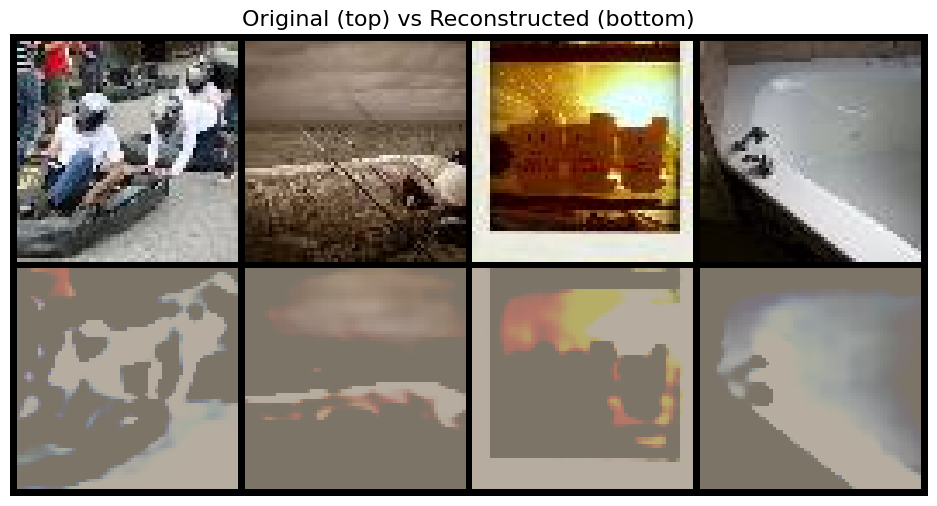

In [7]:
visualize_reconstructions(model, val_loader, device, num_samples=4)

In [8]:
results = trainer.post_training_evaluation(
    val_loader=val_loader,
    save_dir='evaluation_results',
    num_samples=1000
)

Starting comprehensive post-training evaluation...

VALIDATION SET EVALUATION
Computing comprehensive metrics on 1000 samples...


Evaluating:  10%|█         | 32/313 [00:02<00:25, 11.14it/s]



VALIDATION METRICS:
------------------
MSE:  0.034936 ± 0.025426
PSNR: 15.88 ± 3.78 dB
SSIM: 0.6263 ± 0.1571
LPIPS: 0.2202 ± 0.0255
FID:  99.37

Latent Space Analysis:
  Dimensions: 512
  Active dims: 368
  Mean activation: 0.7943
  Total variance: 112.4758
Samples evaluated: 1000

Evaluation results saved to: evaluation_results/comprehensive_evaluation.json
Evaluation plots saved to: evaluation_results


**2.4 Comment on evaluation metrics**

**Reconstruction Metrics:**

* MSE (0.035): Moderate pixel-level error
* PSNR (15.9 dB): Poor - Well below good threshold of 20+ dB

**Perceptual Metrics:**

* SSIM (0.626): Poor - Below good threshold of 0.8, indicates blurry/distorted reconstructions
* LPIPS (0.220): Poor - High perceptual distance (good is <0.1)

**Distributional Metrics:**

* FID (99.37): Very Poor - Much higher than good threshold of <50

**Latent Space:**

* Utilization (72%): Decent - 368/512 dimensions active
* Activation patterns: Reasonable spread and variance

**Bottom Line:**

The autoencoder struggles with reconstruction quality across all perceptual measures. The latent space utilization is okay, but the model produces blurry, perceptually poor reconstructions that don't match the real data distribution well.

Suggestions: Increase model capacity, adjust loss function (add perceptual losses), or train longer.

### 3. Variational Autoencoders

**Core Concept:**

- Standard AE: Input → Latent Code → Reconstruction
- VAE: Input → Probability Distribution → Sample → Reconstruction

**Key Innovation:**

- Instead of fixed latent codes, learns mean (μ) and variance (σ²)
- Latent space becomes a continuous probability distribution
- Can generate new samples by sampling from learned distribution

**Loss Function:**

- Reconstruction Loss: How well it rebuilds input (MSE/BCE)
- KL Divergence: Forces latent distribution close to N(0,1)
- Total: Loss = Reconstruction + β*KL_divergence

**Benefits:**

- Generative: Can create new samples (unlike standard AE)
- Smooth latent space: Interpolation between points works well
- Regularized: KL loss prevents overfitting to training data

**Key Insight:**

- VAE trades perfect reconstruction for meaningful, structured latent space that enables generation and smooth interpolation.

**3.1. Load glasses dataset**

In [3]:
transform = T.Compose([
            T.Resize(256),
            T.ToTensor(),
            ])
data = torchvision.datasets.ImageFolder(
    root="data/glasses",
    transform=transform)
batch_size=16
loader = torch.utils.data.DataLoader(data,
     batch_size=batch_size,shuffle=True)

**3.2 Build a variational autoencoder**

In [7]:
latent_dims=100
class Encoder(nn.Module):
    def __init__(self, latent_dims=100):  
        super().__init__()
        # input 256 by 256 by 3 channels
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        # 128 by 128 with 8 channels
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # 64 by 64 with 16 channels
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        # 31 by 31 with 32 channels
        self.linear1 = nn.Linear(31*31*32, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
        self.linear3 = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        std = torch.exp(self.linear3(x))
        z = mu + std*self.N.sample(mu.shape)
        return mu, std, z  

In [8]:
class Decoder(nn.Module):   
    def __init__(self, latent_dims=100):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 31*31*32),
            nn.ReLU(True))
        self.unflatten = nn.Unflatten(dim=1, 
                  unflattened_size=(32,31,31))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,stride=2,
                               output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1))
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x  

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z) 

In [12]:
vae=VAE().to(device)
lr=1e-4 
optimizer=torch.optim.Adam(vae.parameters(),
                           lr=lr,weight_decay=1e-5)

**3.3. Train the Variational Autoencoder**

In [13]:
def train_epoch(epoch):
    vae.train()
    epoch_loss = 0.0
    for imgs, _ in loader: 
        imgs = imgs.to(device)
        mu, std, out = vae(imgs)
        # reconstruction loss
        reconstruction_loss = ((imgs-out)**2).sum() 
        # kl loss
        kl = ((std**2)/2 + (mu**2)/2 - torch.log(std) - 0.5).sum()
        # total loss
        loss = reconstruction_loss + kl
        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        epoch_loss+=loss.item()
    print(f'at epoch {epoch}, loss is {epoch_loss}')  

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_epoch():
    with torch.no_grad():
        noise = torch.randn(18,latent_dims).to(device)
        imgs = vae.decoder(noise).cpu()
        imgs = torchvision.utils.make_grid(imgs,6,3).numpy()
        fig, ax = plt.subplots(figsize=(6,3),dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")
        plt.show()      

at epoch 1, loss is 49310821.015625


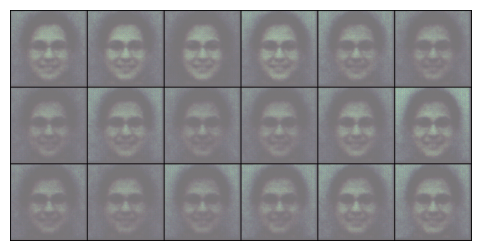

at epoch 2, loss is 35011963.455078125


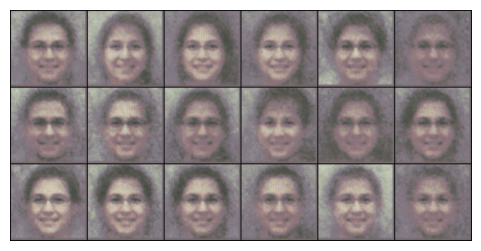

at epoch 3, loss is 23912977.427734375


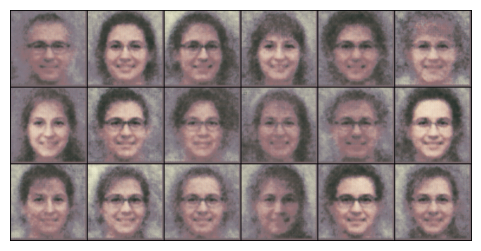

at epoch 4, loss is 18293264.78125


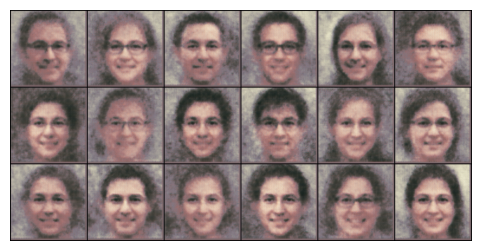

at epoch 5, loss is 15131457.349609375


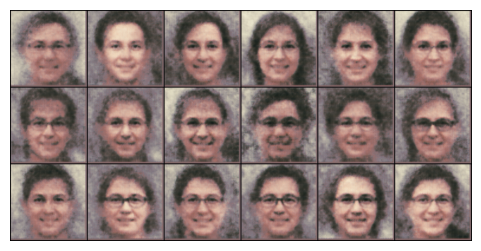

at epoch 6, loss is 13006117.9375


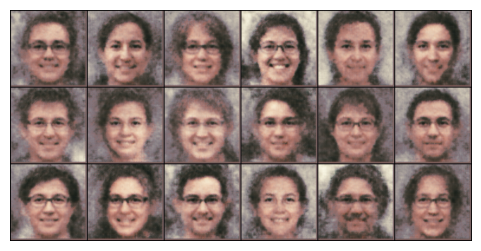

at epoch 7, loss is 11409817.936523438


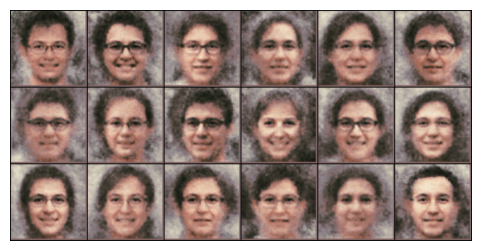

at epoch 8, loss is 10336189.825195312


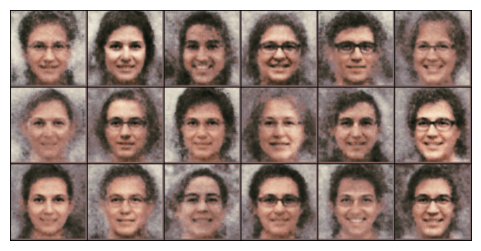

at epoch 9, loss is 9581256.637695312


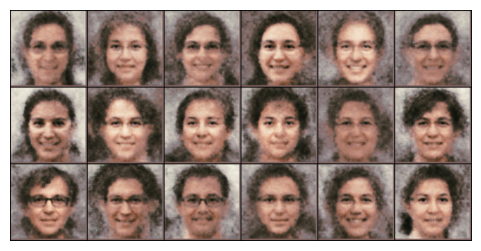

at epoch 10, loss is 8981061.82421875


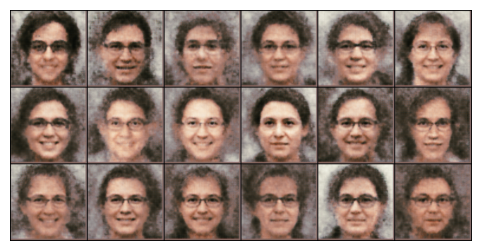

In [17]:
for epoch in range(1,11):
    train_epoch(epoch)
    plot_epoch()
torch.save(vae.state_dict(),"files/VAEglasses.pth")    

**3.4. Generate Images with the Trained Model**

In [18]:
vae.eval()
vae.load_state_dict(torch.load('files/VAEglasses.pth',
                              map_location=device))

<All keys matched successfully>

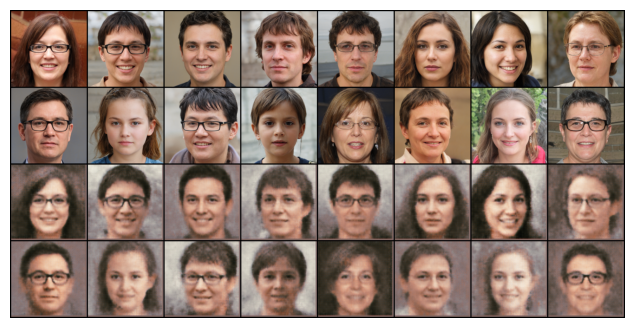

In [19]:
# compare original with reconstructed
imgs,_=next(iter(loader))
imgs = imgs.to(device)
mu, std, out = vae(imgs)
images=torch.cat([imgs,out],dim=0).detach().cpu()
images = torchvision.utils.make_grid(images,8,4)
fig, ax = plt.subplots(figsize=(8,4),dpi=100)
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis("off")
plt.show()      